### Machine Learning não supervisionado

In [1]:
import numpy as np
import pandas as pd
import itertools
import cv2
import os
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from skimage.filters import sobel
from skimage import io
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from matplotlib import pyplot as plt

### K-Means

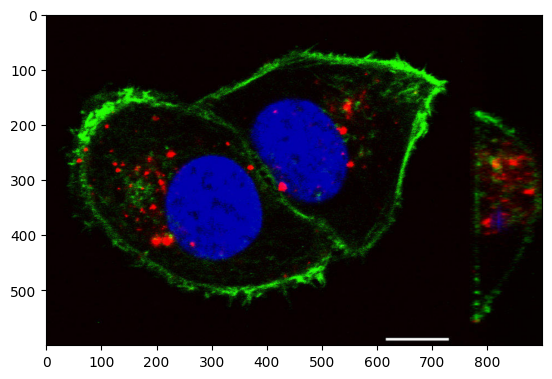

In [2]:
current_dir = os.getcwd()
image_path = os.path.join(current_dir, '..', 'Dados_processamento_imagens', 'cancer_cell.jpg')

img = io.imread(image_path, as_gray=False)
plt.imshow(img, cmap='gray')

c:\venv\ilumpy-VS\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\venv\ilumpy-VS\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


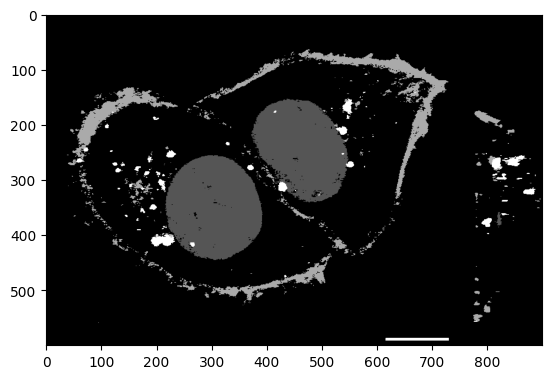

In [3]:
img2 = img.reshape((-1, 3))  #-1 reshape means, in this case MxN
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
model = kmeans.fit(img2)
predicted_values = kmeans.predict(img2)

#res = center[label.flatten()]
segm_image = predicted_values.reshape((img.shape[0], img.shape[1]))
plt.imshow(segm_image, cmap='gray')

### Gaussian Mixture Model (GMM)

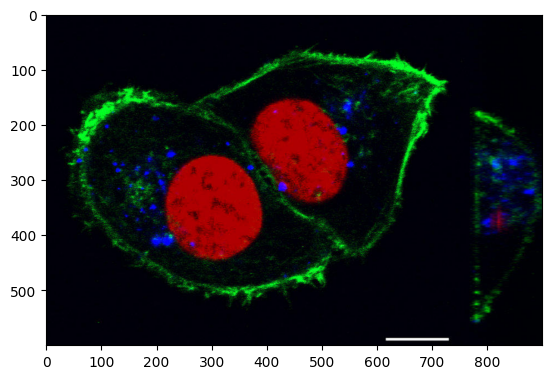

In [4]:
img = cv2.imread(image_path)
plt.imshow(img)

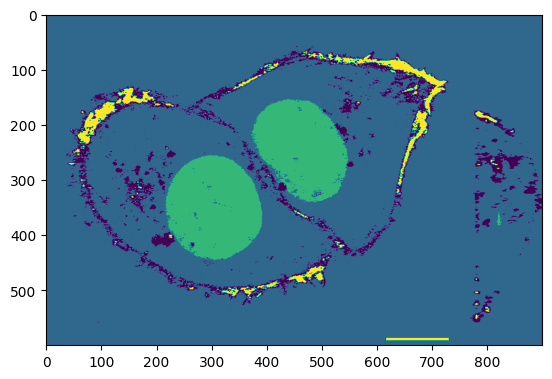

In [5]:
img2 = img.reshape((-1,3))  #-1 reshape means, in this case MxN

#covariance choices, full, tied, diag, spherical
gmm_model = GMM(n_components=4, covariance_type='tied').fit(img2)  #tied works better than full
gmm_labels = gmm_model.predict(img2)

#Put numbers back to original shape so we can reconstruct segmented image
original_shape = img.shape
segmented = gmm_labels.reshape(original_shape[0], original_shape[1])
plt.imshow(segmented)
#cv2.imwrite("images/segmented.jpg", segmented)

bic_value: 12988999.017875373


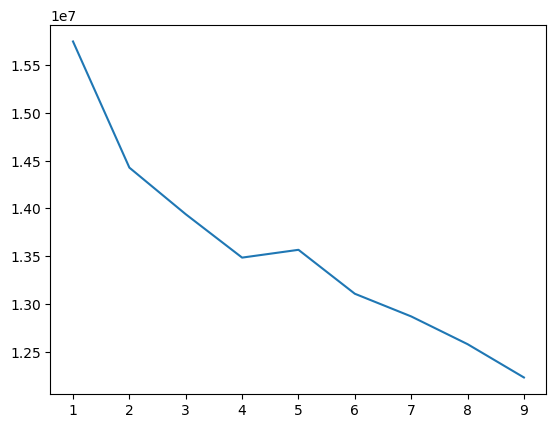

In [6]:
img = cv2.imread(image_path)
img2 = img.reshape((-1,3))

n = 6
gmm_model = GMM(n, covariance_type='tied').fit(img2)
#The above line generates GMM model for n=4
#Now let us call the bic method (or aic if you want).

bic_value = gmm_model.bic(img2)  #Remember to call the same model name from above)
print(f'bic_value: {bic_value}')  #You should see bic for GMM model generated using n=4.
#Do this exercise for different n values and plot them to find the minimum.

n_components = np.arange(1,10)
gmm_models = [GMM(n, covariance_type='tied').fit(img2) for n in n_components]
plt.plot(n_components, [m.bic(img2) for m in gmm_models], label='BIC')
plt.show()

### Filtro Gabor

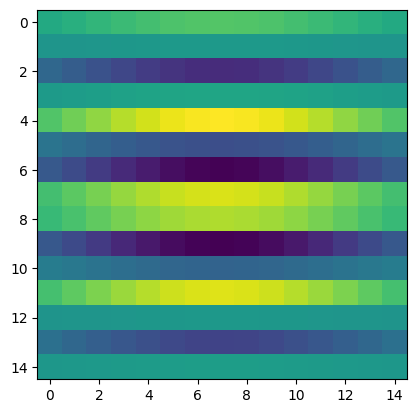

In [7]:
ksize = 15  #Use size that makes sense to the image and fetaure size. Large may not be good. 
#On the synthetic image it is clear how ksize affects imgae (try 5 and 50)
sigma = 5 #Large sigma on small features will fully miss the features. 
theta = 1*np.pi/2  #/4 shows horizontal 3/4 shows other horizontal. Try other contributions
lamda = 1*np.pi/4  #1/4 works best for angled. 
gamma=0.9  #Value of 1 defines spherical. Calue close to 0 has high aspect ratio
#Value of 1, spherical may not be ideal as it picks up features from other regions.
phi = 0.8  #Phase offset. I leave it to 0. (For hidden pic use 0.8)


kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

plt.imshow(kernel)

### Aplicando o Kernel do Gabor

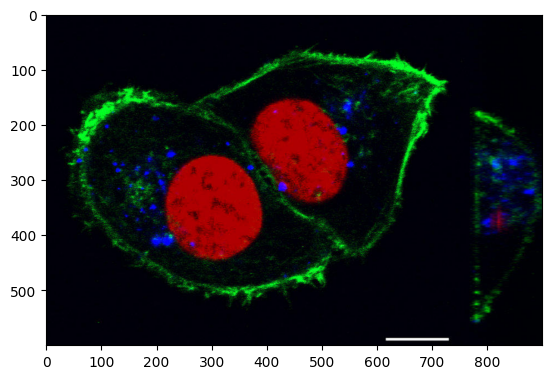

In [8]:
img = cv2.imread(image_path)
plt.imshow(img, cmap='gray')

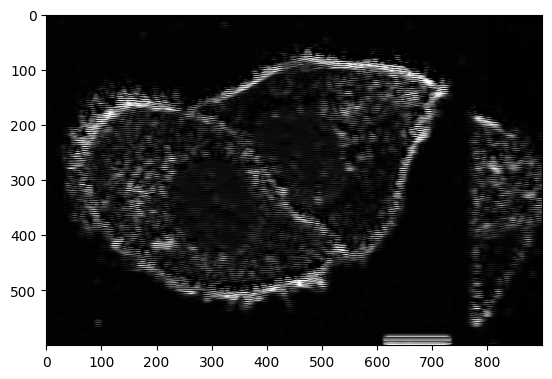

In [9]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

kernel_resized = cv2.resize(kernel, (400, 400))                    # Resize image

plt.imshow(kernel_resized)
plt.imshow(fimg, cmap='gray')

#cv2.imshow('Kernel', kernel_resized)
#cv2.imshow('Original Img.', img)
#cv2.imshow('Filtered', fimg)
#cv2.waitKey()
#cv2.destroyAllWindows()

### Extração de Features

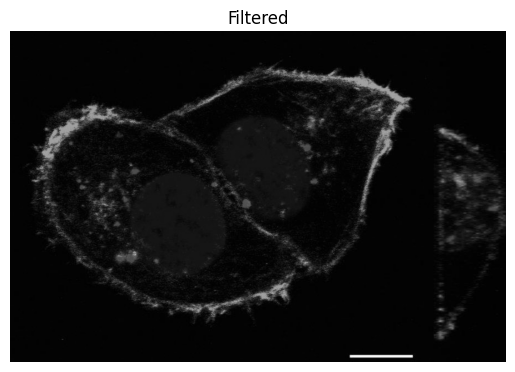

In [10]:
# https://youtu.be/ywyomOyXpxg
 
#img = cv2.imread('BSE_Image.jpg')
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
#Here, if you have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 
plt.imshow(img, cmap='gray')
plt.title('Filtered')
plt.axis('off')  # Hide axes
plt.show()

In [11]:
# Preallocate DataFrame with the correct size
num_pixels = img.size
num_gabor_features = 8 * 4 * 4 * 2  # Number of combinations of Gabor features
df = pd.DataFrame(np.zeros((num_pixels, num_gabor_features + 1)), columns=['Original Image'] + [f'Gabor{i}' for i in range(1, num_gabor_features + 1)])

# Store original image pixels in the DataFrame
df['Original Image'] = img.ravel()

# Generate Gabor features
num = 1  # To count numbers up in order to give Gabor features a label
kernels = []  # Create an empty list to hold all kernels that we will generate in a loop

# Define parameter ranges
thetas = [theta / 4. * np.pi for theta in range(8)]
sigmas = [1, 3, 5, 7]
lamdas = np.arange(0, np.pi, np.pi / 4)
gammas = [0.05, 0.5]

# Iterate through all combinations of parameters
for theta, sigma, lamda, gamma in itertools.product(thetas, sigmas, lamdas, gammas):
    gabor_label = f'Gabor{num}'  # Label Gabor columns as Gabor1, Gabor2, etc.
    ksize = 5  # Try 15 for hidden image. Or 9 for others
    phi = 0  # 0.8 for hidden image. Otherwise leave it to 0
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    kernels.append(kernel)
    
    # Now filter the image and add values to the corresponding column
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)  # Corrected to filter the original image
    df[gabor_label] = fimg.ravel()
    
    # Save filtered image
    cv2.imwrite(f'images/gabor_filtered_images/{gabor_label}.jpg', fimg)
    
    print(f'{gabor_label}: theta={theta}, sigma={sigma}, lamda={lamda}, gamma={gamma}')
    
    num += 1  # Increment for Gabor column label

print(df.head())

# df.to_csv("Gabor.csv")


Gabor1: theta=0.0, sigma=1, lamda=0.0, gamma=0.05
Gabor2: theta=0.0, sigma=1, lamda=0.0, gamma=0.5
Gabor3: theta=0.0, sigma=1, lamda=0.7853981633974483, gamma=0.05
Gabor4: theta=0.0, sigma=1, lamda=0.7853981633974483, gamma=0.5
Gabor5: theta=0.0, sigma=1, lamda=1.5707963267948966, gamma=0.05
Gabor6: theta=0.0, sigma=1, lamda=1.5707963267948966, gamma=0.5
Gabor7: theta=0.0, sigma=1, lamda=2.356194490192345, gamma=0.05
Gabor8: theta=0.0, sigma=1, lamda=2.356194490192345, gamma=0.5
Gabor9: theta=0.0, sigma=3, lamda=0.0, gamma=0.05
Gabor10: theta=0.0, sigma=3, lamda=0.0, gamma=0.5
Gabor11: theta=0.0, sigma=3, lamda=0.7853981633974483, gamma=0.05
Gabor12: theta=0.0, sigma=3, lamda=0.7853981633974483, gamma=0.5
Gabor13: theta=0.0, sigma=3, lamda=1.5707963267948966, gamma=0.05
Gabor14: theta=0.0, sigma=3, lamda=1.5707963267948966, gamma=0.5
Gabor15: theta=0.0, sigma=3, lamda=2.356194490192345, gamma=0.05
Gabor16: theta=0.0, sigma=3, lamda=2.356194490192345, gamma=0.5
Gabor17: theta=0.0, sigma